In [56]:
import numpy as np
from matplotlib import pyplot as plt
import math
import random

In [57]:
def f(x):
    return 3 * x**2 - 2 * x + 1

In [58]:
y = f(3.0)
y

22.0

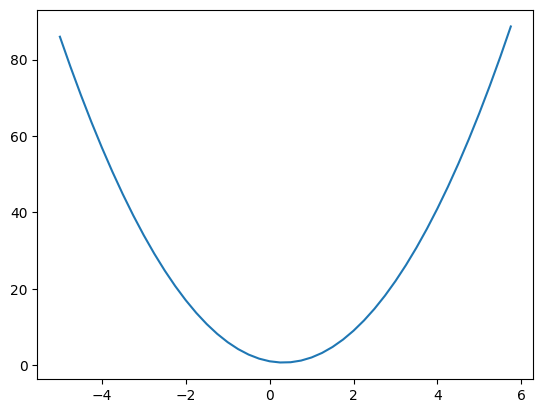

In [59]:
xs = np.arange(-5, 6, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [60]:
h = 0.000000000000001
x = 0.35
df = (f(x + h) - f(x)) / h
df

0.11102230246251564

In [61]:
h = 0.0001

a = 2.0
b = -2.0
c = 5.0
d1 = a * b + c
c += h
d2 = a * b + c
print(d2, (d2 - d1) / h)

1.0000999999999998 0.9999999999976694


In [62]:
class Value:
    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(
            other, (int, float)
        ), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f"**{other}")

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad

        out._backward = _backward

        return out

    def __rmul__(self, other):  # other * self
        return self * other

    def __truediv__(self, other):  # self / other
        return self * other**-1

    def __neg__(self):  # -self
        return self * -1

    def __sub__(self, other):  # self - other
        return self + (-other)

    def __radd__(self, other):  # other + self
        return self + other

    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, (self,), "tanh")

        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward

        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), "exp")

        def _backward():
            self.grad += (
                out.data * out.grad
            )  # NOTE: in the video I incorrectly used = instead of +=. Fixed here.

        out._backward = _backward

        return out

    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [63]:
a = Value(2.0, label="a")
a.grad = -8.0
b = Value(-2.0, label="b")
b.grad = 8.0
c = Value(5.0, label="c")
c.grad = 4.0
e = a * b
e.label = "e"
e.grad = 4.0
d = e + c
d.label = "d"
d.grad = 4.0
f = Value(4.0, label="f")
f.grad = 1.0
L1 = d * f
L1.label = "L"
L1.grad = 1.0

In [64]:
from graphviz import Digraph


def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def plot_dot(root):
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"})  # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(
            name=uid,
            label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad),
            shape="record",
        )
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

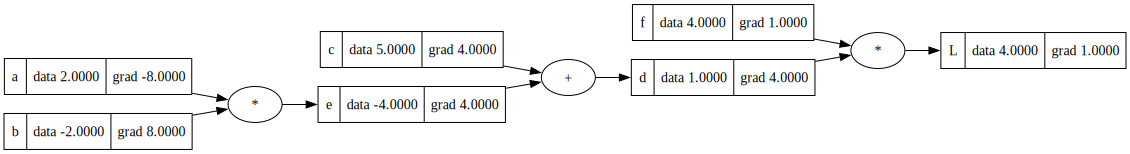

In [65]:
plot_dot(L1)

In [66]:
def lol():
    h = 1e-4

    a = Value(2.0, label="a")
    b = Value(-2.0, label="b")
    c = Value(5.0, label="c")
    e = a * b
    e.label = "e"
    d = e + c
    d.label = "d"
    f = Value(4.0, label="f")
    L1 = d * f
    L1.label = "L"
    L1.grad = 1.0

    a = Value(2.0, label="a")
    b = Value(-2.0, label="b")
    c = Value(5.0, label="c")
    e = a * b
    e.label = "e"
    d = e + c
    d.label = "d"
    d.data += h
    f = Value(4.0, label="f")
    L2 = d * f
    L2.label = "L"
    L2.grad = 1.0

    return (L2.data - L1.data) / h


lol()

3.9999999999995595

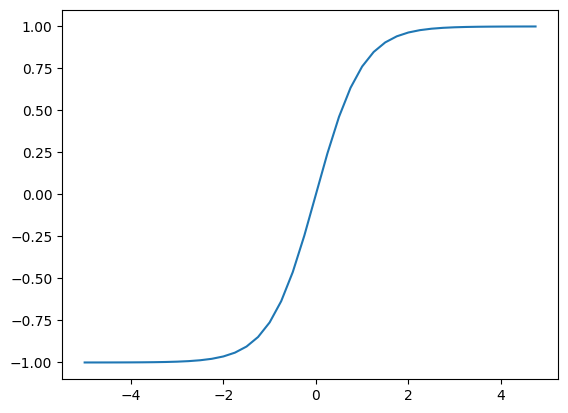

In [67]:
xs = np.arange(-5, 5, 0.25)
ys = np.tanh(xs)
plt.plot(xs, ys)

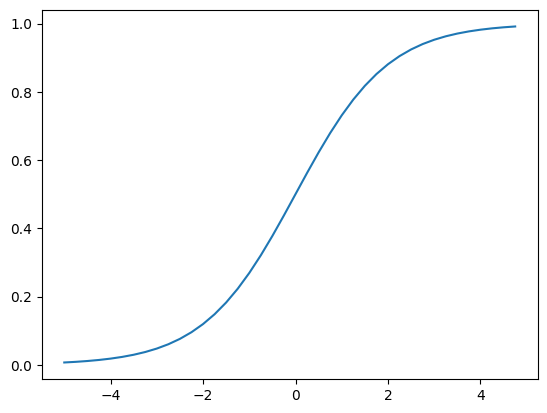

In [68]:
xs = np.arange(-5, 5, 0.25)
ys = 1 / (1 + np.exp(-xs))  # sigmoid
plt.plot(xs, ys)

In [69]:
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

b = Value(6.8813736870195432, label="b")

x1w1 = x1 * w1
x1w1.label = "x1w1"
x2w2 = x2 * w2
x2w2.label = "x2w2"

w1x1w2x2 = x1w1 + x2w2
w1x1w2x2.label = "x1w1 + x2w2"

n = w1x1w2x2 + b
n.label = "n"
o = n.tanh()
o.label = "o"


In [70]:
o.grad = 1.0

n.grad = o.grad * (1 - o.data**2)

w1x1w2x2.grad = n.grad
b.grad = n.grad

x1w1.grad = w1x1w2x2.grad
x2w2.grad = w1x1w2x2.grad

w1.grad = x1.data * x1w1.grad
x1.grad = w1.data * x1w1.grad

w2.grad = x2.data * x2w2.grad
x2.grad = w2.data * x2w2.grad

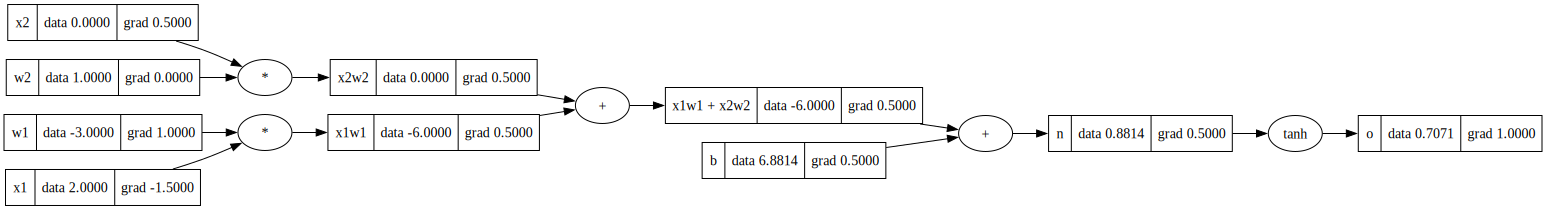

In [71]:
plot_dot(o)

In [72]:
# inputs x1,x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
# weights w1,w2
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
# bias of the neuron
b = Value(6.8813735870195432, label="b")
# x1*w1 + x2*w2 + b
x1w1 = x1 * w1
x1w1.label = "x1*w1"
x2w2 = x2 * w2
x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = "x1*w1 + x2*w2"
n = x1w1x2w2 + b
n.label = "n"
o = n.tanh()
o.label = "o"

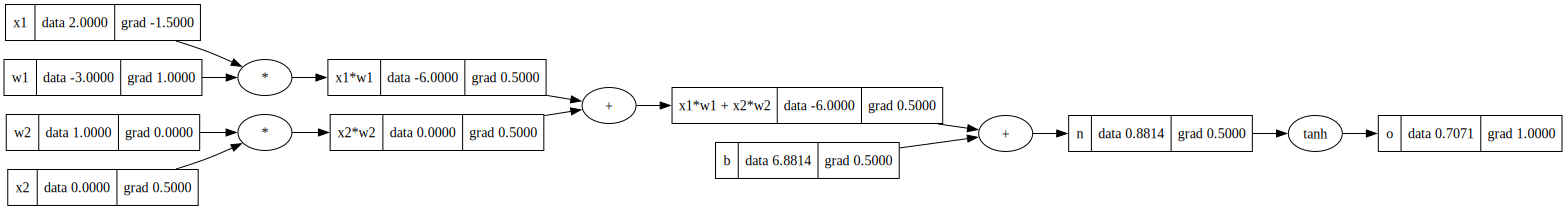

In [73]:
o.backward()

plot_dot(o)

In [74]:
# inputs x1,x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
# weights w1,w2
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
# bias of the neuron
b = Value(6.8813735870195432, label="b")
# x1*w1 + x2*w2 + b
x1w1 = x1 * w1
x1w1.label = "x1*w1"
x2w2 = x2 * w2
x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = "x1*w1 + x2*w2"
n = x1w1x2w2 + b
n.label = "n"
# tanh(n):
e = (2*n).exp()
o = (e - 1) / (e + 1)
o.label = "o"

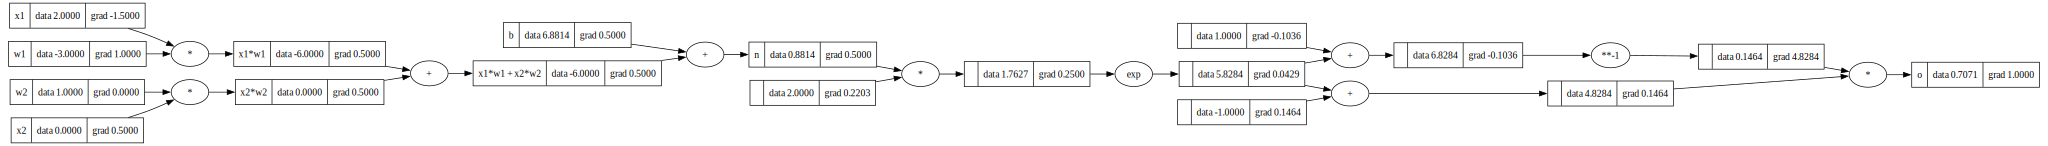

In [75]:
o.backward()

plot_dot(o)

In [76]:
from torch import Tensor

x1 = Tensor([2.0]).double()
x1.requires_grad = True

x2 = Tensor([0.0]).double()
x2.requires_grad = True


w1 = Tensor([-3.0]).double()
w1.requires_grad = True

w2 = Tensor([1.0]).double()
w2.requires_grad = True

b = Tensor([6.8813735870195432]).double()
b.requires_grad = True

n = x1 * w1 + x2 * w2 + b
o = n.tanh()

o.backward()

print(o.data.item())
print("--------------------")
x1.grad, x2.grad, w1.grad, w2.grad, b.grad

0.7071066904050358
--------------------


(tensor([-1.5000], dtype=torch.float64),
 tensor([0.5000], dtype=torch.float64),
 tensor([1.0000], dtype=torch.float64),
 tensor([0.], dtype=torch.float64),
 tensor([0.5000], dtype=torch.float64))

In [237]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        act = sum(([x*w for x, w in zip(x, self.w)]), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]


class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for l in self.layers:
            x = l(x)
        return x
    
    def parameters(self):
        return [p for l in self.layers for p in l.parameters()]

In [291]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
mlp = n(x)
len(n.parameters())

41

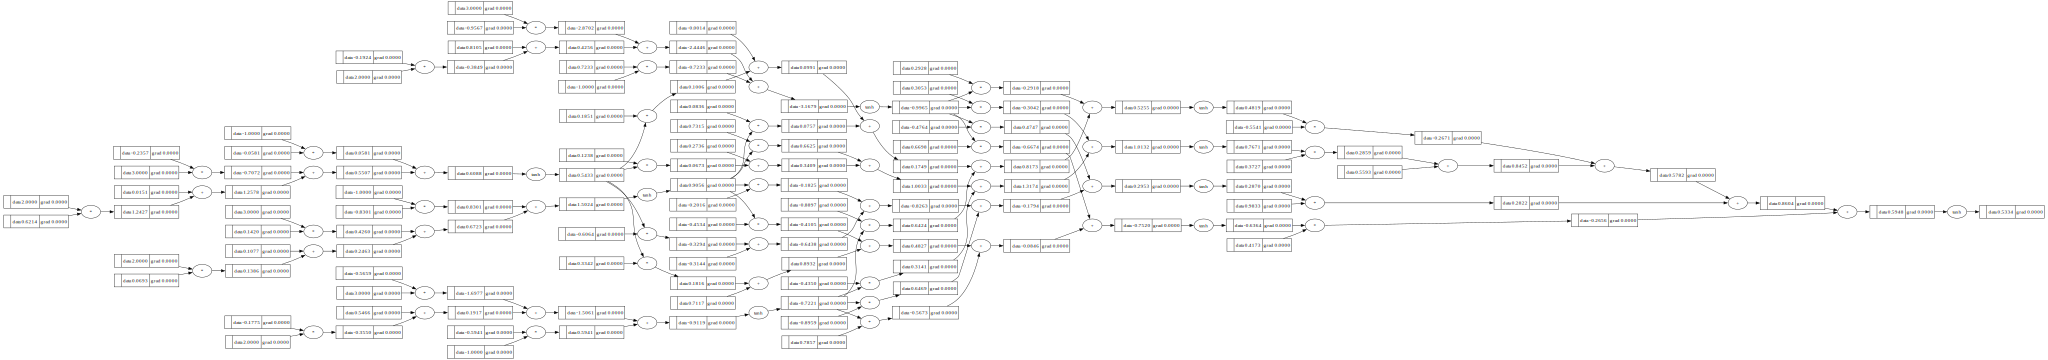

In [292]:
plot_dot(mlp)

In [293]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]
ypreds = [n(x) for x in xs]
ypreds

[Value(data=0.5333541131403184),
 Value(data=0.10004765490677131),
 Value(data=0.6212285742079036),
 Value(data=0.43426665004313064)]

In [294]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypreds))
loss

Value(data=4.376299539870559)

In [295]:
loss.backward()

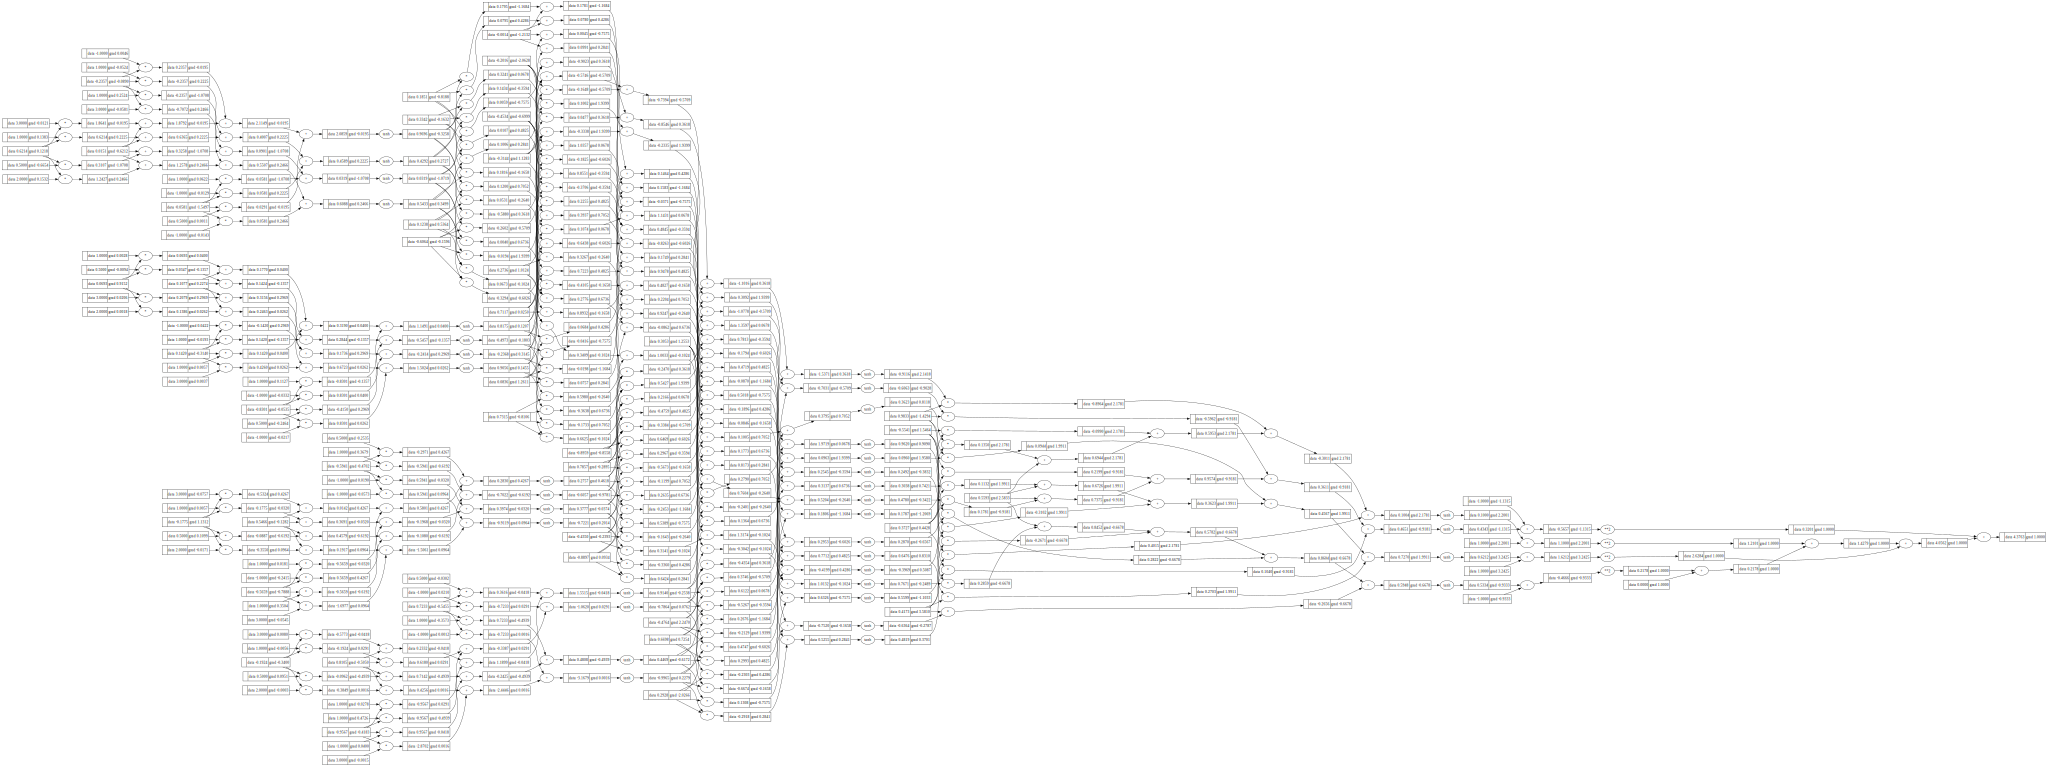

In [296]:
plot_dot(loss)

In [297]:
n.layers[0].neurons[0].w[0].grad

0.12184230114670136

In [298]:
for k in range(1000):
    # forward pass
    ypreds = [n(x) for x in xs]
    loss = sum((yout - ygt) ** 2 for ygt, yout in zip(ys, ypreds))

    # backward pass

    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # update
    for p in n.parameters():
        p.data += -0.5 * p.grad

    print(k, loss.data)

0 4.376299539870559
1 0.48478586462672624
2 7.995015308567577
3 7.991437714592349
4 7.96838327996499
5 4.475154344405506
6 3.221291343737441e-07
7 3.221243676095519e-07
8 3.2211960099013144e-07
9 3.221148345153897e-07
10 3.221100681855841e-07
11 3.221053020003348e-07
12 3.221005359598682e-07
13 3.2209577006422946e-07
14 3.2209100431316236e-07
15 3.2208623870694074e-07
16 3.2208147324536637e-07
17 3.22076707928437e-07
18 3.2207194275626535e-07
19 3.220671777287377e-07
20 3.220624128459447e-07
21 3.2205764810778045e-07
22 3.220528835142736e-07
23 3.220481190654876e-07
24 3.2204335476125946e-07
25 3.220385906018278e-07
26 3.2203382658686227e-07
27 3.220290627166947e-07
28 3.220242989910647e-07
29 3.220195354099678e-07
30 3.220147719735853e-07
31 3.220100086818319e-07
32 3.2200524553459025e-07
33 3.220004825320535e-07
34 3.219957196739549e-07
35 3.219909569606412e-07
36 3.2198619439176306e-07
37 3.219814319674875e-07
38 3.2197666968771904e-07
39 3.219719075525461e-07
40 3.219671455618795e-

In [301]:
ypreds

[Value(data=0.9996398123740002),
 Value(data=-0.9999907602109186),
 Value(data=-0.99999040066634),
 Value(data=0.9995669257341638)]